In [2]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import json
import os
import glob

## Stable baselines implementation

In [16]:
#TD3, 50000
#SAC, 90000

pickle_path = "../output/rates_delay_loss_SAC_1_env.pickle"
pickle_path = "../output/rates_delay_loss_SAC_1_env_WIRED_200kbps.pickle"
pickle_path = "../output_mp/rates_delay_loss_TD3_WIRED_35mbps_400_delay_True_norm_states_False_tuned_True.pickle"
pickle_path = "../output_mp/rates_delay_loss_TD3_WIRED_900kbps_400_delay_True_norm_states_True_tuned_False.pickle"
# pickle_path = "../output_mp/rates_delay_loss_TD3_WIRED_35mbps_200_delay_True_norm_states_True_tuned_False.pickle"
pickle_path = "../output_mp/rates_delay_loss_PPO_WIRED_900kbps_400_delay_False_norm_states_False_tuned_True.pickle"

l_rate = pd.read_pickle(pickle_path)

time_step = 400

In [17]:
trace = list(l_rate.keys())[0]
trace

'./traces/WIRED_900kbps.json'

In [18]:
len(l_rate[trace])

5

In [7]:
l_rate[list(l_rate.keys())[0]]

{0: defaultdict(list,
             {'bandwidth_prediction': [17750,
               17750,
               21244,
               18543,
               11911,
               10310,
               10023,
               10008,
               10010,
               10007,
               10008,
               10011,
               10011,
               10013,
               10016,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10015,
               10014,
               10012,
               10011,
               10010,
               10008,
               10008,
        

In [6]:
len(l_rate[list(l_rate.keys())[0]][13]["bandwidth_prediction"])

KeyError: 13

Trace: ./traces/WIRED_35mbps.json


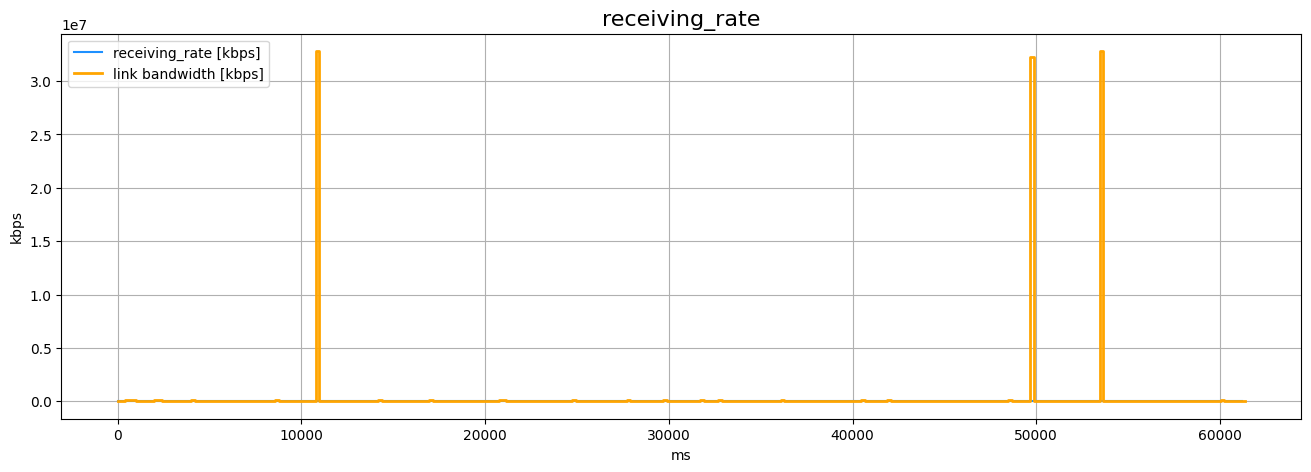

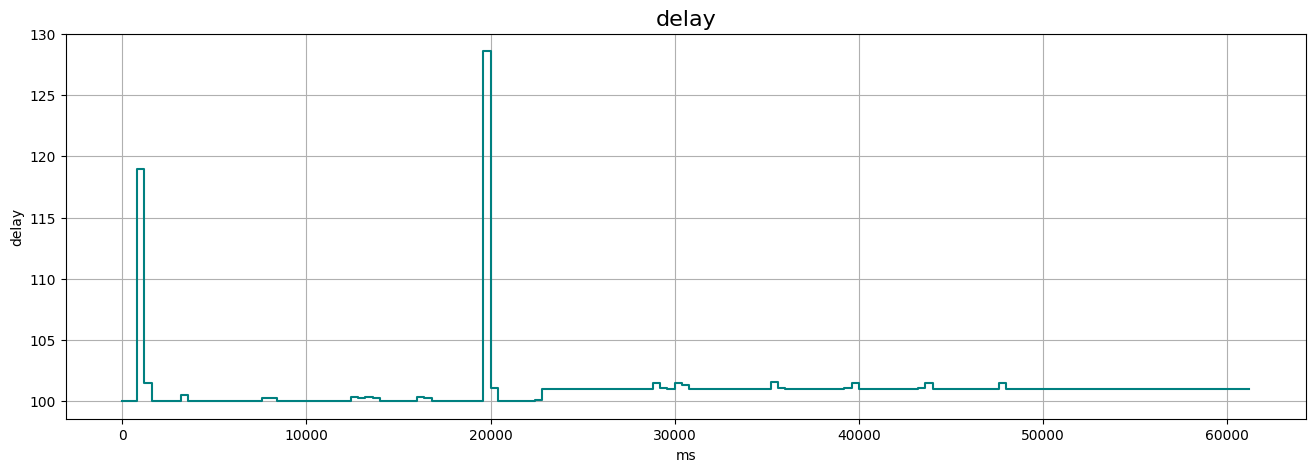

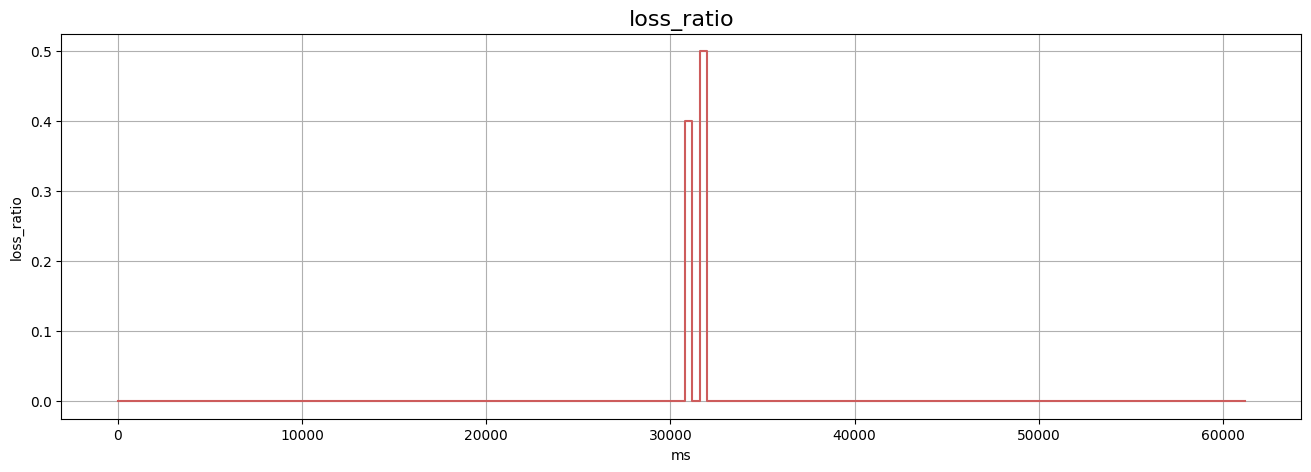

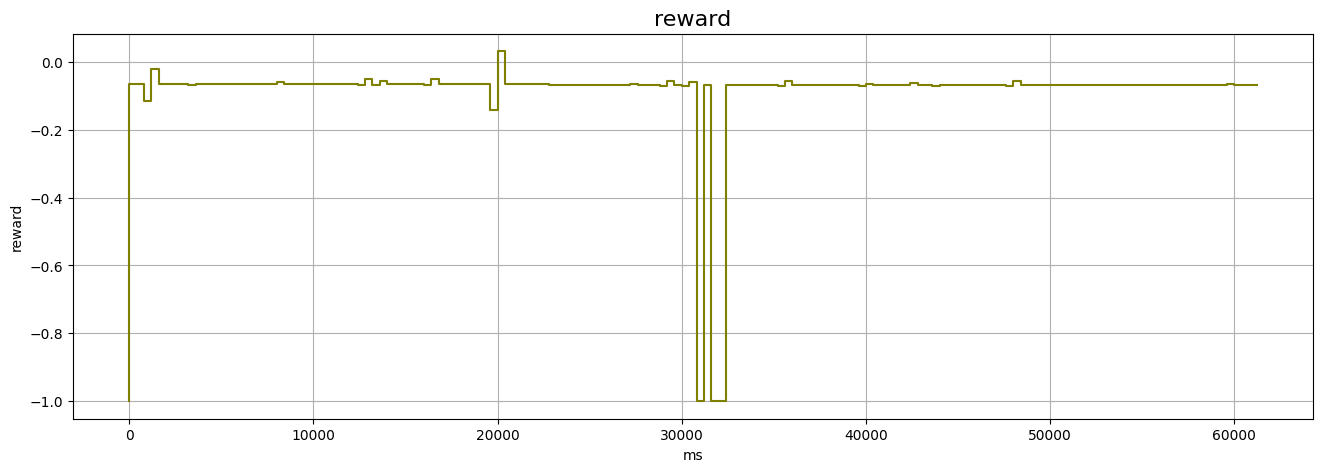

In [15]:
m = 1
for key in l_rate.keys():
    
    print(f"Trace: {key}")
    colors = iter(["dodgerblue", "teal", "indianred", "olive", "red", "green"])

    # for metric in ["bandwidth_prediction", "receiving_rate", "sending_rate", "delay", "loss_ratio", "reward"]:
    for metric in ["receiving_rate", "delay", "loss_ratio", "reward"]:
        #Define capacity

        trace_name = key
        trace_name = "../" + trace_name.split("/")[1] + "/" + trace_name.split("/")[2]

        with open(trace_name, "r") as f:
            d = json.load(f)

        df = pd.DataFrame(d["uplink"]["trace_pattern"])
        time = [0] + list(df["duration"].cumsum())
        capacities = [df["capacity"].iloc[0]] + list(df["capacity"])    

        df_rate = pd.DataFrame(l_rate[key][m][metric], columns=[metric])

        t = np.arange(len(df_rate))*time_step
        df_rate["time"] = t
        df_rate.set_index("time", inplace=True)

        if metric in ["bandwidth_prediction", "sending_rate", "receiving_rate"]:

            plt.figure(figsize=(16,5))
            plt.title(metric, fontsize=16)
            plt.step(df_rate.index, df_rate[metric]/1000, label=f"{metric} [kbps]", color=next(colors))
            plt.step(time, capacities, lw=2, label="link bandwidth [kbps]", color="orange")
            plt.legend()
            plt.ylabel("kbps")
            plt.xlabel("ms")
            plt.grid()
            # plt.ylim((0, 10000))

        else:
            plt.figure(figsize=(16,5))
            plt.title(metric, fontsize=16)
            plt.step(df_rate.index, df_rate[metric], label=f"{metric}", color=next(colors))
            plt.ylabel(metric)
            plt.xlabel("ms")
            plt.grid()
            
        plt.show()

## Calculate scores

##### Be careful of 0 capacity in trace file! - we replace it with a really big number to get U=0, check

In [16]:
traces = list(l_rate.keys())
print(traces)
trace_for_qoe = traces[0]
trace_for_qoe

['./traces/WIRED_900kbps.json']


'./traces/WIRED_900kbps.json'

In [17]:
def make_bandwidth_series(current_trace, step_time):
    #read bandwidth file and create series
    #index timestamps, values bandwidth
    with open(current_trace, "r") as f:
        d = json.load(f)
    df = pd.DataFrame(d["uplink"]["trace_pattern"])
    time = [0] + list(df["duration"].cumsum())
    capacities = [df["capacity"].iloc[0]] + list(df["capacity"])
    s = pd.Series(index=pd.to_datetime(time, unit="ms"), data=capacities)
    capacities = s.resample(f"{step_time}ms").ffill()
    return capacities

### 1 QoE Utilization - receiving rate

In [19]:
metric = "receiving_rate"

#Define capacity
trace_name = "../" + trace_for_qoe.split("/")[1] + "/" + trace_for_qoe.split("/")[2]

capacities = make_bandwidth_series(trace_name, time_step)

df_rate = pd.DataFrame(l_rate[trace_for_qoe][metric], columns=[metric])

t = np.arange(len(df_rate))*time_step
df_rate["time"] = pd.to_datetime(t, unit="ms")
df_rate.set_index("time", inplace=True)

receiving_rate_kbps = df_rate["receiving_rate"]/1000
capacities_kbps = capacities.replace(0, 100000000)

U = receiving_rate_kbps / capacities_kbps
U

time
1970-01-01 00:00:00.000    0.264304
1970-01-01 00:00:00.200    0.923443
1970-01-01 00:00:00.400    0.676608
1970-01-01 00:00:00.600    0.530076
1970-01-01 00:00:00.800    0.109620
                             ...   
1970-01-01 00:00:56.800    0.303155
1970-01-01 00:00:57.000    0.259847
1970-01-01 00:00:57.200    0.302239
1970-01-01 00:00:57.400    0.232543
1970-01-01 00:00:57.600    0.232543
Length: 289, dtype: float64

(0.0, 1.0)

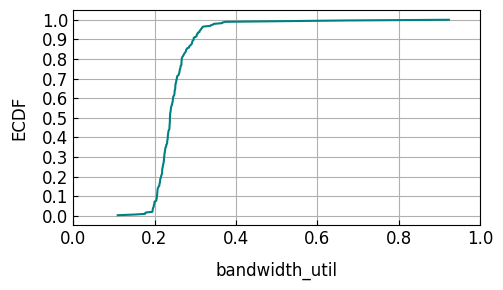

In [21]:
plot_cdf(U, "bandwidth_util", figsize=(5,3))
plt.xlim(0,1)

In [22]:
qoe_rr = 100*U.mean()
qoe_rr

24.850540826618047

### 2 QoE delay

In [24]:
metric = "delay"

df_rate = pd.DataFrame(l_rate[trace_for_qoe][metric], columns=[metric])

t = np.arange(len(df_rate))*time_step
df_rate["time"] = pd.to_datetime(t, unit="ms")
df_rate.set_index("time", inplace=True)

delay = df_rate["delay"]

<AxesSubplot:>

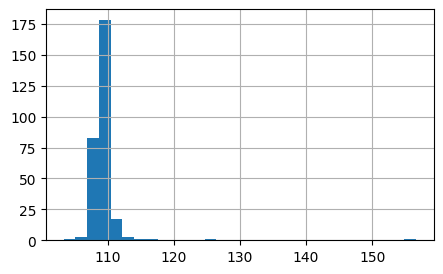

In [26]:
delay.hist(bins=30, figsize=(5,3))

In [27]:
d_max = delay.max()
d_min = delay.min()
d_95 = delay.quantile(0.95)

In [28]:
qoe_delay = 100*(d_max-d_95)/(d_max - d_min)
qoe_delay

85.5421686746988

### 3 QoE losses

In [29]:
metric = "loss_ratio"

df_rate = pd.DataFrame(l_rate[trace_for_qoe][metric], columns=[metric])

t = np.arange(len(df_rate))*time_step
df_rate["time"] = pd.to_datetime(t, unit="ms")
df_rate.set_index("time", inplace=True)

loss_ratio = df_rate["loss_ratio"]

In [30]:
L = loss_ratio.mean()
L

0.0

In [31]:
qoe_losses = 100*(1-L)
qoe_losses

100.0

### 4 Overall QoE

In [32]:
qoe = 0.2*qoe_rr + 0.2*qoe_delay + 0.3*qoe_losses
qoe

52.078541900263374